# Week 4: IPO Portfolio Optimizer – GRU-Based Allocation

## Problem Setup

### Problem Statement
Optimize daily portfolio weights between **Market** (S&P 500 + Dow proxy) and **IPO Index** (market-cap weighted, 180-day post-IPO). A GRU neural network maps rolling windows of past returns to allocations.

### Mathematical Formulation
- **Loss (minimize):** $L = -\mu_p + \lambda_{cvar} L_{cvar} + \lambda_{vol} \sigma_p^2 + \lambda_{vol\_excess} \max(0, \sigma_{ann} - \tau) + \lambda_{turn} |w-w_{prev}| + \lambda_{path} \|w-w_{prev}\|^2$
- **Model:** $w = \text{softmax}(\text{MLP}(\text{GRU}(x)))$
- **Constraints:** Long-only, fully invested via softmax

### Data Requirements
- WRDS: SDC + CRSP (IPO dates, prices, shares); SPY/DIA for market

### Success Metrics
- Validation Sharpe > 1.5, Max DD < 15%, beat market baseline

## Implementation

### Imports and Path Setup

In [1]:
import sys
import json
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(ROOT))

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from src.wrds_data import get_connection, load_ipo_data_from_sdc_wrds, load_sdc_ipo_dates_wrds
from src.wrds_data import load_sp500_dow_market_returns_wrds
from src.data_layer import align_returns, add_optional_features, build_rolling_windows, train_val_split
from src.train import run_training
from src.export import predict_weights, portfolio_stats, export_summary
from src.model import build_model

### Data Preparation (uses run_ipo_optimizer_wrds.prepare_data)

We reuse the prepare_data logic from the main script. Requires WRDS credentials.

In [2]:
# Import prepare_data from run script
from run_ipo_optimizer_wrds import prepare_data, load_best_config, ROOT

conn = get_connection()
data_prep = prepare_data(conn)
df = data_prep['df']
feature_cols = data_prep['feature_cols']

print(f"Data shape: {df.shape}")
print(f"Features: {feature_cols}")
df.head()

Loading library list...


Done


IPO data from SDC + CRSP: 770418 rows, 1136 tickers


IPO tickers: 1136, Date range: 2020-01-02 to 2024-12-31


Market return days: 1258, Tickers with shares: 1136


IPO index: 1248 days with valid returns
Data shape: (1248, 4)
Features: ['market_return', 'ipo_return', 'rolling_vol', 'vix']


,market_return,ipo_return,rolling_vol,vix
2020-01-16,0.00842,0.000000,0.0041,20.0
2020-01-17,0.002847,0.000000,0.0041,20.0
2020-01-21,-0.002489,0.074221,0.0041,20.0
2020-01-22,0.000087,0.070362,0.0041,20.0
2020-01-23,0.000774,-0.012300,0.0041,20.0


### Build Rolling Windows and Split

**Key parameters:** window_len=126, val_frac=0.2 (last 20% for validation)

In [3]:
cfg = load_best_config()
X, R, dates = build_rolling_windows(df, window_len=cfg['window_len'], feature_cols=feature_cols)
X_train, R_train, d_train, X_val, R_val, d_val = train_val_split(X, R, dates, val_frac=cfg['val_frac'])

data = {
    'X_train': X_train, 'R_train': R_train, 'dates_train': d_train,
    'X_val': X_val, 'R_val': R_val, 'dates_val': d_val,
    'feature_cols': feature_cols, 'df': df, 'n_assets': 2, 'window_len': cfg['window_len']
}
print(f"Train windows: {X_train.shape[0]}, Val windows: {X_val.shape[0]}")
print(f"Input shape: (batch, seq_len={X_train.shape[1]}, features={X_train.shape[2]})")

Train windows: 898, Val windows: 224
Input shape: (batch, seq_len=126, features=4)


### Objective Function and Training

**Loss terms:** mean return (max), CVaR, variance, vol excess, turnover, path instability. All implemented in `src.losses.combined_loss`.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, history = run_training(
    data, device=device,
    epochs=cfg['epochs'], lr=cfg['lr'], batch_size=cfg['batch_size'], patience=cfg['patience'],
    lambda_vol=cfg['lambda_vol'], lambda_cvar=cfg['lambda_cvar'],
    lambda_vol_excess=cfg.get('lambda_vol_excess', 1.0),
    target_vol_annual=cfg.get('target_vol_annual', 0.25),
    hidden_size=cfg['hidden_size'], model_type='gru',
)
print(f"Trained for {len(history)} epochs")

Trained for 11 epochs


## Validation

### Performance on Validation Set

In [5]:
weights = predict_weights(model, data['X_val'], device)
stats = portfolio_stats(weights, data['R_val'])

print('Validation Metrics:')
for k, v in stats.items():
    if isinstance(v, float):
        print(f'  {k}: {v:.4f}' if v < 10 else f'  {k}: {v:.2%}')
print(f"\nAverage IPO weight: {weights[:, 1].mean():.2%}")

Validation Metrics:
  mean_return_daily: 0.0015
  volatility_daily: 0.0089
  total_return: 0.3940
  return_annualized: 0.4530
  volatility_annualized: 0.1407
  sharpe_annualized: 2.7284
  max_drawdown: -0.0760
  avg_turnover: 0.0000

Average IPO weight: 20.44%


### Baseline Comparison

In [6]:
w_mkt = np.tile([1., 0.], (R_val.shape[0], 1))
w_ipo = np.tile([0., 1.], (R_val.shape[0], 1))
w_eq = np.tile([0.5, 0.5], (R_val.shape[0], 1))

s_mkt = portfolio_stats(w_mkt, R_val)
s_ipo = portfolio_stats(w_ipo, R_val)
s_eq = portfolio_stats(w_eq, R_val)

print('Model:      Sharpe={:.2f}  MaxDD={:.2%}'.format(stats['sharpe_annualized'], stats['max_drawdown']))
print('Market:     Sharpe={:.2f}  MaxDD={:.2%}'.format(s_mkt['sharpe_annualized'], s_mkt['max_drawdown']))
print('IPO only:   Sharpe={:.2f}  MaxDD={:.2%}'.format(s_ipo['sharpe_annualized'], s_ipo['max_drawdown']))
print('Equal 50/50: Sharpe={:.2f}  MaxDD={:.2%}'.format(s_eq['sharpe_annualized'], s_eq['max_drawdown']))

Model:      Sharpe=2.73  MaxDD=-7.60%
Market:     Sharpe=1.53  MaxDD=-7.89%
IPO only:   Sharpe=3.75  MaxDD=-10.08%
Equal 50/50: Sharpe=3.47  MaxDD=-7.20%


### Training / Validation Loss Curve

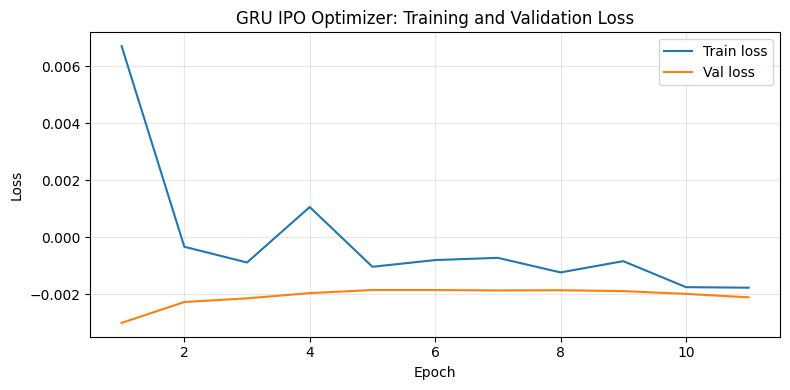

In [7]:
epochs_x = [h['epoch'] for h in history]
plt.figure(figsize=(8, 4))
plt.plot(epochs_x, [h['train_loss'] for h in history], label='Train loss')
plt.plot(epochs_x, [h['val_loss'] for h in history], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GRU IPO Optimizer: Training and Validation Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Documentation

### Key Parameters
- **window_len**: 126 days (half year) of history per prediction
- **val_frac**: 0.2 – last 20% of dates held out for validation
- **lambda_vol_excess**: penalize when annual vol exceeds target_vol_annual (default 25%)
- **hidden_size**: 64 – GRU hidden dimension

### Known Limitations
- No true out-of-sample test period
- Weights are near-constant (low turnover)
- Survivorship bias in IPO index

### Next Steps
- Add test set split (e.g., last 3–6 months)
- Diagnose why weights are static; consider reducing turnover penalty
- Add transaction cost term to loss